In [84]:
import numpy as np
import pandas as pd
import pickle
import re
import os

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
!pip install contractions

     |████████████████████████████████| 312 kB 31.5 MB/s eta 0:00:01
     |████████████████████████████████| 238 kB 36.5 MB/s eta 0:00:01
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81695 sha256=417b148b6aa5bdb34e5a7e8b5222144b3630ceb3d176386634baf3c5ca2b8801
  Stored in directory: /root/.cache/pip/wheels/16/ec/84/27daa7f8d8c0bdad46f462e2834faa13cfda30ea07097e0e3d
Successfully built pyahocorasick


In [13]:
!pip install nltk

     |████████████████████████████████| 1.4 MB 14.3 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 679 kB 47.4 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434675 sha256=745a736b341dae6bf116de2a912fb4ec233804d1fc5646e9fad0bd63b852f774
  Stored in directory: /root/.cache/pip/wheels/de/5e/42/64abaeca668161c3e2cecc24f864a8fc421e3d07a104fc8a51
Successfully built nltk


In [18]:
!pip install gensim==3.8.1

     |████████████████████████████████| 24.2 MB 2.2 MB/s eta 0:00:011
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.2
    Uninstalling gensim-3.8.2:
      Successfully uninstalled gensim-3.8.2


In [4]:
import contractions

In [8]:
DATA_DIRECTORY = 'storage/buttersbot/'

In [9]:
DUMP_FILE = "combined_data.p"

# Preprocess the text

In [87]:
data = pickle.load(open(os.path.join(DATA_DIRECTORY, DUMP_FILE), "rb"))

In [138]:
data.head()

,class,tweet,id
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,3
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,4


In [139]:
data = data.reset_index(drop=True)

In [140]:
data.head()

,class,tweet,id
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,3
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,4


In [119]:
data.loc[201]

class                                                    1
tweet    "@Nicholas_ted33: Kobe stay talking trash. But...
id                                                     203
Name: 201, dtype: object

In [120]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

In [121]:
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, stem_text, strip_short, strip_non_alphanum, strip_numeric

#### Choosing to tokenize first or links and mentions will pollute the data when split out
Unfortunately, this process will be slower since every token has to be checked instead of whole tweet

In [122]:
# Create a partial of strip_short to set the min length. Default is 3
from functools import partial
strip_short2 = partial(strip_short, minsize=2)

In [123]:
uri_pattern = re.compile(r'[A-z]://.*')
def remove_link(token):
    """
    If the token is a uri then simply don't return anything back
    """    
    if not re.match(uri_pattern, token):
        return token
    
    return

In [124]:
def remove_mention(token):
    """
    If the token starts with an @ then return none otherwise return the token
    """
    if not token.startswith('@'):
        return token
    
    return

In [125]:
def remove_punc(token):
    """
    Removes tokens that are only punctuation 
    """
    token = re.sub(r'\W', "", token)
    return token if token else None
    

In [126]:
def remove_numeric(token):
    """
    Remove numeric only tokens.  They don't add value to this classification
    """
    return token if not token.isnumeric() else None

In [127]:
def remove_rt(token):
    """
    Most common word in the vocabulary is RT remove this to clean up
    """
    token = token.replace("rt", "")
    return token if token else None

In [128]:
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [129]:
def preprocess_tweet(tweet):
    """
    Work through the tweet and do the following:
    * Tokenize with a tweet specific tokenizer
    * take a pass through all the tokens running tests on each one
    """
    globa_process_list = [str.lower, contractions.fix, remove_accented_chars]
    process_list = [str.lower, str.strip, remove_link, remove_mention, remove_punc, 
                    remove_rt, strip_non_alphanum, strip_numeric, strip_short2, remove_stopwords, stem_text]
        
    # Process global things done on entire tweet
    for func in globa_process_list:
        tweet = func(tweet)
    
    # Now tokenize
    tokens = tweet_tokenizer.tokenize(tweet)

    # Clean tokens
    processed_tokens = []
    for token in tokens:
        for func in process_list:
            token = func(token)
            if not token:
                break
        else:
            processed_tokens.append(token)
    
    return processed_tokens
    

In [130]:
preprocess_tweet("!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...#buildthewall")

['woman', 'complain', 'clean', 'hous', 'man', 'trash', 'buildthewal']

In [131]:
tokenized_tweets = [preprocess_tweet(pt) for pt in data['tweet']]

In [132]:
tokenized_tweets[0]

['woman', 'complain', 'clean', 'hous', 'man', 'trash']

#### Pickle the tokenized tweets

In [133]:
TOKENIZED_DUMP = "tokenized_tweets.p"

In [134]:
pickle.dump(tokenized_tweets, open(os.path.join(DATA_DIRECTORY, TOKENIZED_DUMP), "wb"))

### Now we are going to glue them all back together to be able to create BOW and TDIDF matrices


In [135]:
corpus = [" ".join(tweet) for tweet in tokenized_tweets]

In [136]:
corpus[0]

'woman complain clean hous man trash'

#### Pickle the corpus


In [108]:
PREPROCESSED_CORPUS_DUMP = "preprocessed_corpus.p"
pickle.dump(corpus, open(os.path.join(DATA_DIRECTORY, PREPROCESSED_CORPUS_DUMP), "wb"))

### Finding a vocabulary to use
Ideal is supposed to be around 10000

In [109]:
from nltk.lm import Vocabulary
import itertools

In [110]:
vocab = Vocabulary(itertools.chain(*tokenized_tweets))

In [111]:
word_list = []
freq_list = []
for word, freq in vocab.counts.most_common():
    word_list.append(word)
    freq_list.append(freq)

In [112]:
freq_list[5000]

7

In [113]:
#To graph this we need a subset of each or the graph will explode
x_axis = word_list[0:1000:50]
y_axis = freq_list[0:1000:50]

In [114]:
len(x_axis), len(y_axis)

(20, 20)

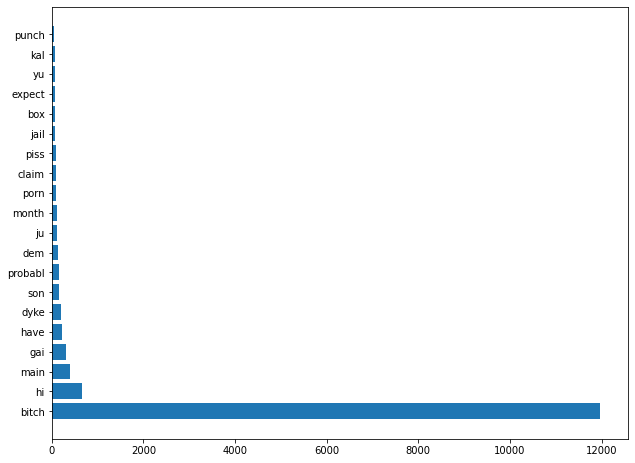

In [115]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0, 0, 1, 1])
ax.barh(x_axis, y_axis)
plt.show()

#### Findings

The frequency drops of fast. By 750 the frequency is < 100 and by 5000 it is < 10. We will probably cut of at frequency 5 just to have something useful.

In [116]:
vocab_final = Vocabulary(itertools.chain(*tokenized_tweets), unk_cutoff=5)

#### Pickle the vocab


In [117]:
VOCAB_DUMP = "vocab.p"

In [118]:
pickle.dump(vocab_final, open(os.path.join(DATA_DIRECTORY, VOCAB_DUMP), "wb"))